In [1]:
import keras
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('voc.csv')
data = data.drop('Unnamed: 0', 1)
data['File_Path'] = './VOCdevkit2007/VOC2007/JPEGImages/' + data['Frame']
#data = data[(data['label'] == 0)].reset_index()
print(data.head())

        Frame   xmin   xmax   ymin   ymax  label  type  \
0  003815.jpg  188.0  433.0  108.0  213.0    0.0  test   
1  003815.jpg  231.0  259.0    1.0   54.0    1.0  test   
2  003815.jpg  186.0  219.0    1.0   54.0    1.0  test   
3  003815.jpg  242.0  274.0   11.0   95.0    1.0  test   
4  003815.jpg  288.0  333.0  125.0  149.0    1.0  test   

                                       File_Path  
0  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
3  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
4  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  


In [3]:
def csv2bbox(bbox):
    gta = np.zeros((len(bb_boxes), 4))
    #print(gta.shape)
    #bbox groundtruth before bbox_encode
    for i in range(len(bb_boxes)):
        gta[i, 0] = int(bb_boxes.iloc[i]['xmin'])
        gta[i, 1] = int(bb_boxes.iloc[i]['ymin'])
        gta[i, 2] = int(bb_boxes.iloc[i]['xmax'])
        gta[i, 3] = int(bb_boxes.iloc[i]['ymax'])
    return gta

4


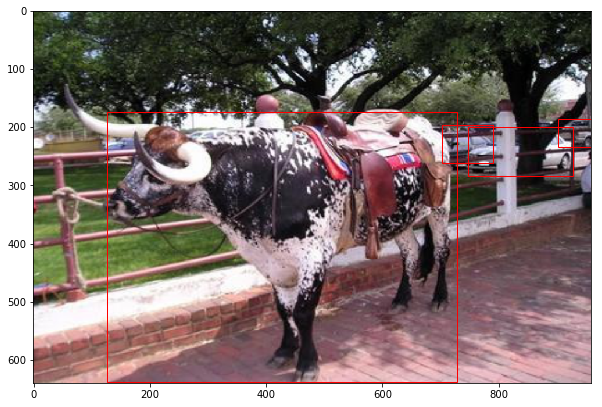

In [4]:
#load img and bbox
import batch_generate
i_line = np.random.randint(len(data))
name_str, img, bb_boxes = batch_generate.get_img_by_name(data, i_line, size = (960, 640))
gta = csv2bbox(bb_boxes)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
print(len(gta))
for i in range(len(gta)):
    currentAxis.add_patch(plt.Rectangle((gta[i,0], gta[i,1]), gta[i,2]-gta[i,0], gta[i,3]-gta[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [5]:
import netarch
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
import losses
input_shape_img = (None, None, 3)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(300, 4))
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = netarch.base_net(img_input, trainable=False)
# define the RPN, built on the base layers
num_anchors = 9
rpn = netarch.rpn(shared_layers, num_anchors)
model_rpn = Model(img_input, rpn[:2])
model_rpn.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)
optimizer = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_classification(num_anchors), losses.rpn_regression(num_anchors)])

In [6]:
y_rpn_cls,y_rpn_regr = batch_generate.label_generate(img, gta)

In [7]:
img_channel_mean = [103.939, 116.779, 123.68]
img_scaling_factor = 1.0
x_img = img.astype(np.float32)
x_img[:, :, 0] -= img_channel_mean[0]
x_img[:, :, 1] -= img_channel_mean[1]
x_img[:, :, 2] -= img_channel_mean[2]
x_img /= img_scaling_factor
bat_img = np.expand_dims(x_img, axis=0)
P_rpn = model_rpn.predict_on_batch(bat_img)

In [8]:
X = bat_img
Y = [y_rpn_cls,y_rpn_regr]
loss_rpn = model_rpn.train_on_batch(X, Y)
P_rpn = model_rpn.predict_on_batch(X)

(50, 4)


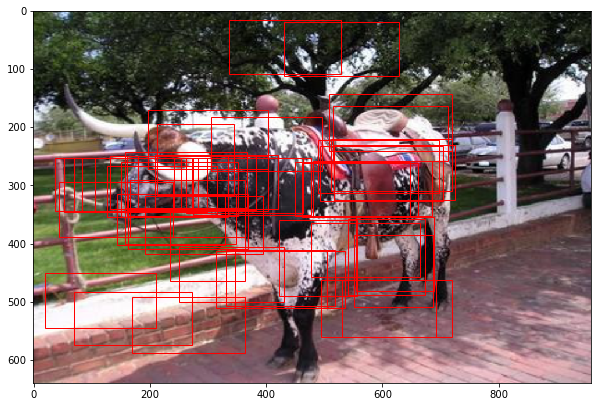

In [9]:
import utils
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 50)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [10]:
loss_rpn = model_rpn.train_on_batch(X, Y)
P_rpn = model_rpn.predict_on_batch(X)

(50, 4)


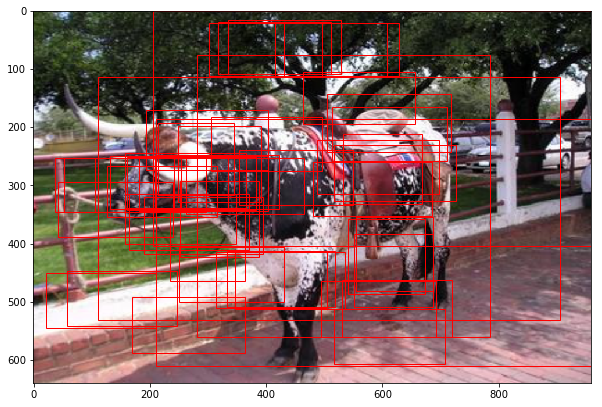

In [11]:
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 50)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

iter 0, loss [0.7930035, 0.6688112, 0.12419228]
iter 1, loss [0.76646155, 0.65543938, 0.11102219]
iter 2, loss [0.74093431, 0.64202869, 0.098905623]
iter 3, loss [0.71643472, 0.62858039, 0.087854303]
iter 4, loss [0.69295555, 0.61506307, 0.07789246]
iter 5, loss [0.67034507, 0.60136425, 0.068980798]
iter 6, loss [0.64856541, 0.58741742, 0.061147992]
iter 7, loss [0.62757778, 0.5731982, 0.054379579]
iter 8, loss [0.60718739, 0.5585736, 0.048613761]
iter 9, loss [0.58742744, 0.54355478, 0.043872669]
iter 10, loss [0.56836224, 0.52824682, 0.040115435]
iter 11, loss [0.55004305, 0.51266903, 0.037373994]
iter 12, loss [0.53240782, 0.49678394, 0.03562386]
iter 13, loss [0.51545459, 0.48067972, 0.03477487]
iter 14, loss [0.49929178, 0.46452326, 0.034768518]
iter 15, loss [0.48377475, 0.44834918, 0.03542557]
iter 16, loss [0.46883401, 0.43230259, 0.036531426]
iter 17, loss [0.45434791, 0.41647923, 0.03786869]
iter 18, loss [0.44018212, 0.40096614, 0.039215993]
iter 19, loss [0.42628002, 0.3859

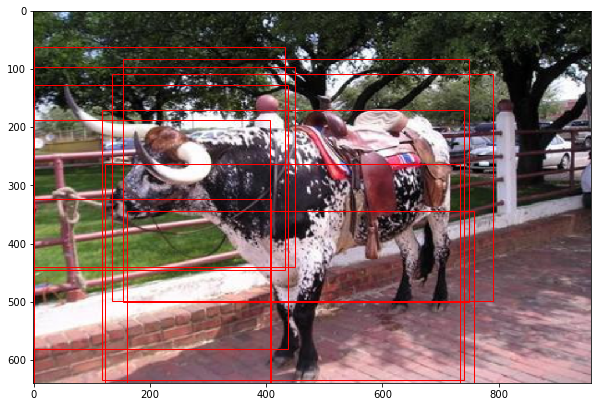

In [12]:
for i in range(100):
    loss_rpn = model_rpn.train_on_batch(X, Y)
    P_rpn = model_rpn.predict_on_batch(X)
    print('iter {0}, loss {1}'.format(i, loss_rpn))
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 10)

plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [13]:
#load pretrained model(this model is only have 1000times training, the training data is pascal voc2007)
#later I will add a classification layer at the end of this network. this version is just sungle
#region proposal network

In [14]:
input_shape_img = (None, None, 3)
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(300, 4))
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = netarch.base_net(img_input, trainable=False)
# define the RPN, built on the base layers
num_anchors = 9
rpn = netarch.rpn(shared_layers, num_anchors)
model_rpn = Model(img_input, rpn[:2])
model_rpn.load_weights('10000rpn.h5', by_name=True)

In [15]:
P_rpn = model_rpn.predict_on_batch(bat_img)

In [16]:
boxes, scores = utils.propose_cpu(P_rpn[1], P_rpn[0], maximum = 20)

(20, 4)


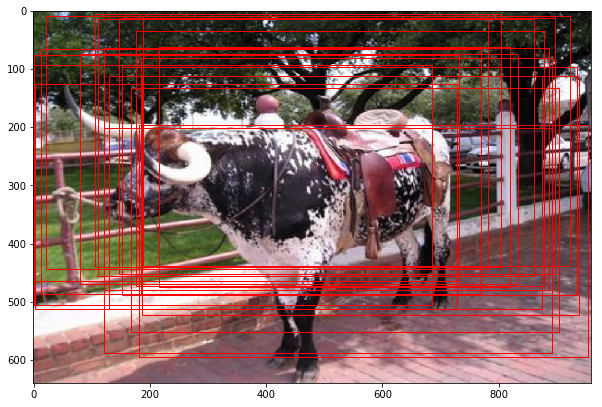

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
box = boxes[0]
print(box.shape)
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))